In [1]:
import re
from collections import Counter
from pathlib import Path

import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Project, csv paths
PROJECT_DIR = Path.cwd().parent
ALL_FLIGHTS_DIR = PROJECT_DIR / "data" / "all_flights" / "all_flights"

assert ALL_FLIGHTS_DIR.exists()

## Flight Header DataFrame

- The dataset is grouped into two - 1) `all_flights/` and 2) `2days/`
- The `all_flights` dataset includes all NGAFID flight data, representing the dataset before partitioning into the `2days` dataset
- The `2days` dataset looks only at flights 2 days before and after a maintenance issue 
- Lets start by loading and looking at out first dataset, found in the `all_fligths/flight_header.csv`

In [3]:
# Path to all_flights flight_header.csv
flight_header_path = ALL_FLIGHTS_DIR / "flight_header.csv"
assert flight_header_path.exists()

flight_header_df = pd.read_csv(flight_header_path, index_col="Master Index")
flight_header_df.index.name = "flight_id"
flight_header_df.head()

,before_after,date_diff,flight_length,label,hierarchy,number_flights_before
flight_id,,,,,,
1,before,-1,4723.0,intake gasket leak/damage,NaN,0
2,before,-2,4649.0,intake gasket leak/damage,NaN,3
3,same,0,40.0,intake gasket leak/damage,NaN,-1
4,before,0,14.0,intake gasket leak/damage,NaN,0
5,same,0,683.0,intake gasket leak/damage,NaN,-1


In [4]:
flight_header_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28935 entries, 1 to 32820
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   before_after           28935 non-null  object 
 1   date_diff              28935 non-null  int64  
 2   flight_length          28935 non-null  float64
 3   label                  28935 non-null  object 
 4   hierarchy              10581 non-null  object 
 5   number_flights_before  28935 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 1.5+ MB


In [5]:
flight_header_df.isna().any()

before_after             False
date_diff                False
flight_length            False
label                    False
hierarchy                 True
number_flights_before    False
dtype: bool

In [6]:
flight_header_df.shape

(28935, 6)

We have 28935 rows of data, with 6 columns  - each row is a flight id, or flight record with length of flight and maintence information/classification

All of our columns are fully populated except the hierarchy column, which has 18,354 null records. Since this column represents the maintance issue hierarchy, we can leave as is for now since we don't plan on doing anything with that column just yet.

We are expecting int64 or float64 type for our "date_diff", "flight_length", and "number_flights_before" columns

The `before_after`, representing whether maintenance occurred before or after the flight, includes the value `same`, meaning maintenance occurred the same day/during maintenance

| Column | Description | Datatype|
| - | - | - |
| Master Index | Flight record primary key, represents a single flight | int |
| before_after | Whether a flight occurred before or after a maintenance action | str |
| date_diff | Days before or after maintenance | int |
| flight_length | Duration of flight in seconds | float |
| label | Maintenance issue, 36 unique issues | str |
| Hierarchy | Maintenance issue category, NaN is other, 5 unique groups | str |
| number_flights_before | The nth flight before maintenance, -1 is N/A, 0 is immediately before | int |


In [7]:
# Number of maintenance hierarchies/categories
flight_header_df["hierarchy"].unique()

array([nan, 'engine', 'baffle', 'oil', 'cylinder'], dtype=object)

In [8]:
# Number of unique maintenance labels
len(flight_header_df["label"].unique())

36

- `label` column is maintence issue type, 36 total classes of maintenance 
- 5 `hierarchy`s of maintenance
    1. Baffle
    2. Cylinder
    3. Engine
    4. Oil
    5. NaN (other)

In [9]:
flight_header_df.head(8)

,before_after,date_diff,flight_length,label,hierarchy,number_flights_before
flight_id,,,,,,
1,before,-1,4723.0,intake gasket leak/damage,NaN,0
2,before,-2,4649.0,intake gasket leak/damage,NaN,3
3,same,0,40.0,intake gasket leak/damage,NaN,-1
4,before,0,14.0,intake gasket leak/damage,NaN,0
5,same,0,683.0,intake gasket leak/damage,NaN,-1
7,after,1,3482.0,intake gasket leak/damage,NaN,-1
8,same,0,263.0,intake gasket leak/damage,NaN,-1
9,before,-1,4979.0,intake gasket leak/damage,NaN,0


In [10]:
flight_header_df.describe()

,date_diff,flight_length,number_flights_before
count,28935.000000,28935.000000,28935.000000
mean,-0.025920,3879.015725,0.121445
std,3.721469,3065.589572,1.634050
min,-108.000000,12.000000,-1.000000
25%,-1.000000,419.000000,-1.000000
50%,0.000000,4402.000000,-1.000000
75%,1.000000,5771.000000,1.000000
max,70.000000,30059.000000,4.000000


Nothing looks out of place for our statistical analysis of the data

Lets look at the `label` column distribution 

In [12]:
# Top maintenance issues
flight_header_df["label"].value_counts().head(10)

label
intake gasket leak/damage                     10140
rocker cover leak/loose/damage                 5219
intake tube/bolt/seal/boot loose or damage     1372
baffle crack/damage/loose/miss                 1294
baffle plug need repair/replace                1142
baffle screw miss/loose                         894
baffle seal loose/damage                        859
engine run rough                                670
baffle tie/tie rod loose or damage              656
engine failure/fire/time out                    643
Name: count, dtype: int64

### Part Name

Many of these labels for maintenance issues have similar aircraft part associated with them, so we can categorize them into `part_name` categories to make our analysis easier. We will create a dictionary of rules of regex patterns to find in each label, and categorize it based on the associated part name.

In [13]:
# Add a PartName column to flight_header_df
Rules = [
    ("baffle kit", r"\bbaffle\s*(seal|crack|spring|mount|tie|bracket)\b"),
    ("baffle screw", r"\bbaffle\s*screw\b"),
    ("baffle plug", r"\bbaffle\s*plug\b"),
    ("baffle rivet ", r"\bbaffle\s*rivet \b"),
    ("intake gasket", r"\bintake\s*gasket\b"),
    ("intake tube/bolt/seal/boot", r"\bintake\s*(tube|bolt|seal|boot)\b"),
    ("engine", r"\bengine\b"),
    ("rocker cover", r"\brocker\s*cover\b"),
    ("oil cooler", r"\boil\s*cooler\b"),
    ("oil pressure", r"\boil\s*(leak|pressure)\b"),
    ("oil dipstick", r"\boil\s*(dipstick|return)\b"),
    ("cowling", r"\bcowling\b"),
    ("cylinder", r"\bcylinder\b"),
    ("drain line/tube", r"\bdrain\s*(line|tube)\b"),
    ("mixture", r"\bmixture\b"),
    ("spark plug", r"\bspark\s*plug\b"),
    ("magneto", r"\bmagneto\b"),
    ("induction", r"\binduction\b"),
    ("other", r".*"),
]


def categorize_part(label: str) -> str:
    """Returns part name category given maintenance label"""
    for part_name, pattern in Rules:
        if re.search(pattern, label, re.IGNORECASE):
            return part_name
    return "other"

In [14]:
flight_header_df["part_name"] = flight_header_df["label"].apply(categorize_part)
flight_header_df["part_name"].value_counts()

part_name
intake gasket                 10140
rocker cover                   5219
baffle kit                     3191
engine                         2959
cylinder                       1578
intake tube/bolt/seal/boot     1372
baffle plug                    1142
baffle screw                    894
other                           831
oil cooler                      312
drain line/tube                 228
baffle rivet                    224
cowling                         211
oil dipstick                    151
magneto                         141
induction                       133
oil pressure                    130
mixture                          40
spark plug                       39
Name: count, dtype: int64

This is much better to look at and analyze, here we can see that intake gaskets are the aircraft part that needs the most maintenance. 

### Maintence Label Prices

Before we look at the second dataset connected to the flight_header_df, we want to include the price it takes to replace each of the partNames above. Unfortunately, this dataset doesn't provide prices, and it was difficult to find any other existing dataset out there that does. This can be because prices are always changing, and can vary from one producer/aircraft type to another.

For our analysis, we have found an online aircraft parts supplier, https://www.chiefaircraft.com/aircraft.html and grabbed the prices they have on their website as of November 11th, 2025. 

Note: The price of "other" was calculated by taking the average of all the other prices

In [15]:
def get_prices_df() -> pd.DataFrame:
    """Returns prices df"""
    prices_csv_path = PROJECT_DIR / "data" / "prices.csv"
    if prices_csv_path.exists():
        return pd.read_csv(prices_csv_path)

    prices = {
        "part_name": [
            "baffle kit",
            "baffle screw",
            "baffle plug",
            "baffle rivet ",
            "intake gasket",
            "intake tube/bolt/seal/boot",
            "engine",
            "rocker cover",
            "oil cooler",
            "oil pressure",
            "oil dipstick",
            "cowling",
            "cylinder",
            "drain line/tube",
            "mixture",
            "spark plug",
            "magneto",
            "induction",
            "other",
        ],
        "price_usd": [
            419.95,
            6.95,
            39.95,
            24.50,
            4.50,
            16.50,
            839.99,
            11.25,
            1189.00,
            265.00,
            8.50,
            1190.00,
            795.00,
            19.95,
            215.95,
            44.00,
            859.00,
            169.00,
            305.95,
        ],
    }
    prices_df = pd.DataFrame(prices)
    prices_df.to_csv(prices_csv_path, index=False)
    return prices_df

In [16]:
prices_df = get_prices_df()
prices_df.head()

,part_name,price_usd
0,baffle kit,419.95
1,baffle screw,6.95
2,baffle plug,39.95
3,baffle rivet,24.50
4,intake gasket,4.50


Need to add `price_usd`, but cannot merge without losing the flight record index, so use the below function to lookup prices

In [17]:
def get_part_price(part_name: str) -> float:
    """Returns price_usd given part_name"""
    mask = prices_df["part_name"] == part_name
    if not mask.any():
        mask = prices_df["part_name"] == "other"
    return prices_df.loc[mask, "price_usd"].item()

In [18]:
flight_header_df["prices_usd"] = flight_header_df["part_name"].apply(get_part_price)

In [19]:
flight_header_df.head()

,before_after,date_diff,flight_length,label,hierarchy,number_flights_before,part_name,prices_usd
flight_id,,,,,,,,
1,before,-1,4723.0,intake gasket leak/damage,NaN,0,intake gasket,4.5
2,before,-2,4649.0,intake gasket leak/damage,NaN,3,intake gasket,4.5
3,same,0,40.0,intake gasket leak/damage,NaN,-1,intake gasket,4.5
4,before,0,14.0,intake gasket leak/damage,NaN,0,intake gasket,4.5
5,same,0,683.0,intake gasket leak/damage,NaN,-1,intake gasket,4.5


In [20]:
flight_header_df.describe()

,date_diff,flight_length,number_flights_before,prices_usd
count,28935.000000,28935.000000,28935.000000,28935.000000
mean,-0.025920,3879.015725,0.121445,218.936975
std,3.721469,3065.589572,1.634050,332.606137
min,-108.000000,12.000000,-1.000000,4.500000
25%,-1.000000,419.000000,-1.000000,4.500000
50%,0.000000,4402.000000,-1.000000,11.250000
75%,1.000000,5771.000000,1.000000,419.950000
max,70.000000,30059.000000,4.000000,1190.000000


In [21]:
flight_header_df.loc[flight_header_df["part_name"] == "other", "label"].value_counts()

label
pilot/in-flight noticed issue    579
aircraft start/external issue    252
Name: count, dtype: int64

The part name labeled "other" is mainly for the labels "aircraft start/external issue" and "pilot/in-flight noticed issue" which don't specify a part as the issue

## (All) Flights Dataset

In [22]:
# Flight Data df
flight_data_path = ALL_FLIGHTS_DIR / "one_parq"
assert flight_data_path.exists()

flight_data_df = dd.read_parquet(flight_data_path)
flight_data_df = flight_data_df.rename_axis("flight_id")
flight_data_df.head()

,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,...,E1 EGT2,E1 EGT3,E1 EGT4,OAT,IAS,VSpd,NormAc,AltMSL,timestep,cluster
flight_id,,,,,,,,,,,,,,,,,,,,,
1,28.8,NaN,0.8,NaN,48.89,44.06,13.28,168.55,82.51,2519.7,...,1317.44,1298.97,1322.83,12.8,144.89,29.61,0.01,3010.7,3151,c_28
1,28.8,NaN,0.8,NaN,48.93,44.06,13.31,168.60,82.51,2519.4,...,1316.64,1300.68,1322.15,12.8,144.53,49.78,-0.00,3011.3,3150,c_28
1,28.8,NaN,0.9,NaN,48.96,44.06,13.36,168.65,82.51,2520.3,...,1317.20,1301.05,1323.12,12.8,144.15,58.68,-0.01,3011.8,3149,c_28
1,28.8,NaN,0.7,NaN,48.86,44.06,13.30,168.64,82.51,2519.3,...,1317.73,1302.14,1321.93,12.8,143.79,47.31,-0.00,3012.2,3148,c_28
1,28.8,NaN,0.6,NaN,48.87,44.06,13.30,168.65,82.51,2518.8,...,1318.00,1308.52,1316.99,12.8,143.45,36.05,-0.01,3012.3,3147,c_28


| Column | Description | Datatype |
| - | - | - |
| volt1 | Main electrical system bus voltage | float |
| volt2 | Essential bus (standby battery) bus voltage | float |
| amp1 | Ammeter on the main battery (+charging, -dicharging) | float |
| amp2 | Ammeter on the standby battery (+charging, -discharging) | float |
| FQtyL | Fuel quantity left | float |
| FQtyR | Fuel quantity right | float |
| E1 FFlow | Engine fuel flow rate | float |
| E1 OilT | Engine oil temperature | float |
| E1 OilP | Engine oil pressure | float |
| E1 RPM | Engine rotations per minute | float |
| E1 CHT1 | 1st cylinder head temperature | float |
| E1 CHT2 | 2nd cylinder head temperature | float |
| E1 CHT3 | 3rd cylinder head temperature | float |
| E1 CHT4 | 4th cylinder head temperature | float |
| E1 EGT1 | 1st exhaust gas temperature | float |
| E1 EGT2 | 2nd exhaust gas temperature | float |
| E1 EGT3 | 3rd exhaust gas temperature| float |
| E1 EGT4 | 4th exhaust gas temperature| float |
| OAT | Outside air temperature | float |
| IAS | Indicated air speed | float |
| VSPd | Vertical speed  | float |
| NormAc | Normal acceleration | float |
| AltMSL | Altitude miles above sea level | float |
| timestep | flight time series step | int |
| cluster | label class | str |

Voltages: volt1, volt2

Amperages: amp1, amp2

Fuel metrics: FQtyL, FQtyR, FFflow

Engine metrics: RPM, OilP, OilT

Temperatures: CHT1–CHT4, EGT1–EGT4

Flight metrics: IAS, VSpd, NormAc

Altitude: AltMSL

Outside Air Temp: OAT

In [137]:
# Number of rows
nrows = flight_data_df.shape[0].compute()
nrows

112239320

- The dask dataframe is evaluated lazily due to the large number of rows (112,239,320)

In [24]:
# Number of unique flights
flight_data_index = flight_data_df.index.compute()
nflights = flight_data_index.nunique()
nflights

28935

- There are 28,935 flight records

In [138]:
# Number of clusters
nclusters = len(flight_data_df["cluster"].unique())
nclusters

36

- 36 unique clusters, matching the number of labels in the header df

The sensor dataset includes NaN values at certain timesteps - this is may be explained by initialization of the sensor at the beginning of the flight, failure of the sensor, and a failure of the recording system

In [ ]:
# Check (feature) columns have NaN values
flight_data_df.isna().any().compute()

volt1        True
volt2        True
amp1         True
amp2         True
FQtyL        True
FQtyR        True
E1 FFlow     True
E1 OilT      True
E1 OilP      True
E1 RPM       True
E1 CHT1      True
E1 CHT2      True
E1 CHT3      True
E1 CHT4      True
E1 EGT1      True
E1 EGT2      True
E1 EGT3      True
E1 EGT4      True
OAT          True
IAS          True
VSpd         True
NormAc       True
AltMSL       True
timestep    False
cluster     False
dtype: bool

In [37]:
# define the 23 sensor/feature columns
feature_columns = [
    "volt1",
    "volt2",
    "amp1",
    "amp2",
    "FQtyL",
    "FQtyR",
    "E1 FFlow",
    "E1 OilT",
    "E1 OilP",
    "E1 RPM",
    "E1 CHT1",
    "E1 CHT2",
    "E1 CHT3",
    "E1 CHT4",
    "E1 EGT1",
    "E1 EGT2",
    "E1 EGT3",
    "E1 EGT4",
    "OAT",
    "IAS",
    "VSpd",
    "NormAc",
    "AltMSL",
]

In [ ]:
# What percentage of the flight data contains NaN?
rows_with_na = flight_data_df[feature_columns].isna().any(axis=1).sum().compute()
pct_na = rows_with_na / nrows * 100
pct_na

- To reduce the dataset size, drop rows with NaN, same day flights, any flights < 30 mins in length, and only flights with +-5 days of maintenance, choosing a timeframe which provides the most data while being able to evaulate as a pandas DataFrame
- Dropping same day flight because it is unclear whether the flight occurs before or after maintenance action
- Dropping short flights because many of those flight's sensor readings include NaN
- Dropping date_diff larger than 5 because most of the data is within 1 day

In [23]:
def get_flight_df(flight_id: int) -> pd.DataFrame:
    """Returns flight data pd.DataFrame for specified flight"""
    one_parq_path = ALL_FLIGHTS_DIR / "one_parq"
    flights_df = dd.read_parquet(
        one_parq_path, filters=[("Master Index", "==", flight_id)]
    )
    flights_df = flights_df.rename_axis("flight_id")
    return flights_df.sort_values(by="timestep").compute()


In [24]:
flight_df = get_flight_df(6866)
flight_df.head()

,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,...,E1 EGT2,E1 EGT3,E1 EGT4,OAT,IAS,VSpd,NormAc,AltMSL,timestep,cluster
flight_id,,,,,,,,,,,,,,,,,,,,,
6866,27.9,27.9,4.1,0.3,23.22,24.0,2.33,64.72,62.93,1019.0,...,938.69,919.91,939.09,-6.2,0.0,-0.14,0.00,842.2,0,c_23
6866,27.9,27.9,4.1,0.3,23.22,24.0,2.33,64.72,62.93,1019.0,...,938.69,919.91,939.09,-6.2,0.0,-0.14,0.00,842.2,1,c_23
6866,28.0,27.9,4.0,0.3,23.24,24.0,2.32,64.77,63.44,1042.1,...,944.93,925.34,943.07,-6.2,0.0,12.19,0.01,841.9,2,c_23
6866,28.0,27.9,4.0,0.4,23.24,24.0,2.58,64.79,64.96,1112.4,...,948.64,928.90,946.87,-6.2,0.0,9.90,0.01,841.8,3,c_23
6866,28.0,27.9,3.9,0.3,23.24,24.0,2.75,64.81,66.73,1193.2,...,955.34,938.93,955.80,-6.2,0.0,7.55,0.01,841.6,4,c_23


In [25]:
def get_cluster_df(cluster: str) -> pd.DataFrame:
    """Returns flight data pd.DataFrame for specified cluster"""
    # Does it already exist?
    parq_path = PROJECT_DIR / "data" / f"{cluster}.parquet"
    if parq_path.exists():
        return pd.read_parquet(parq_path)

    # DataFrame
    one_parq_path = ALL_FLIGHTS_DIR / "one_parq"
    flights_df = dd.read_parquet(one_parq_path, filters=[("cluster", "==", cluster)])
    flights_df = flights_df.rename_axis("flight_id")
    flights_df = flights_df.compute()

    # Save
    flights_df.to_parquet(parq_path)

    return flights_df

In [26]:
def get_label_cluster_map() -> dict[str, str]:
    """Returns label to cluster mapper"""
    label_cluster_map = {}
    labels = flight_header_df["label"].unique()
    for label in labels:
        # filter by label
        mask = flight_header_df["label"] == label
        flight_ids = flight_header_df.loc[mask].index

        # get flight df
        flight_id = flight_ids.values[0]
        flight_df = get_flight_df(flight_id)

        # get cluster
        clusters = flight_df["cluster"].unique()
        assert len(clusters) == 1
        label_cluster_map[label] = list(clusters)[0]
    return label_cluster_map

In [27]:
label_cluster_map = get_label_cluster_map()


In [28]:
# Get engine failure cluster df
cluster = label_cluster_map["engine failure/fire/time out"]
cluster_df = get_cluster_df(cluster)
cluster_df.head()

,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,...,E1 EGT2,E1 EGT3,E1 EGT4,OAT,IAS,VSpd,NormAc,AltMSL,timestep,cluster
flight_id,,,,,,,,,,,,,,,,,,,,,
15551,NaN,NaN,NaN,NaN,23.27,23.75,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.5,0.0,-44.40,0.00,829.9,0,c_21
15551,NaN,NaN,NaN,NaN,23.27,23.75,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.5,0.0,-44.40,0.00,829.9,1,c_21
15551,NaN,NaN,NaN,NaN,23.23,23.75,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.5,0.0,-31.84,0.01,829.5,2,c_21
15551,27.9,27.9,7.0,0.6,23.21,23.73,1.94,73.77,59.70,1062.6,...,983.24,988.20,1005.94,19.5,0.0,-21.67,-0.03,829.7,3,c_21
15551,27.9,27.9,7.0,0.6,23.21,23.73,2.02,73.80,59.75,1064.0,...,985.44,989.95,1008.19,19.5,0.0,15.04,0.02,829.5,4,c_21


In [29]:
def get_hierarchy_df(hierarchy: str) -> pd.DataFrame:
    """Returns df by hierarchy"""
    # Does the file already exist?
    parq_path = PROJECT_DIR / "data" / f"{hierarchy}.parquet"
    if parq_path.exists():
        return pd.read_parquet(parq_path)

    # Filter by hierarchy
    hierarchy_mask = flight_header_df["hierarchy"] == hierarchy

    # Filter Flights > 30 mins
    flight_length_mask = flight_header_df["flight_length"] > 30 * 60

    # Filter Out Same Day Flights
    same_day_mask = flight_header_df["before_after"] != "same"

    # N <= date_diff <= N
    ndays = 4  # +1 to calculate actual number of days
    date_diff_mask = (flight_header_df["date_diff"] >= -ndays) & (
        flight_header_df["date_diff"] <= ndays
    )

    # Create mask
    header_masked = flight_header_df[
        hierarchy_mask & flight_length_mask & same_day_mask & date_diff_mask
    ]
    flight_ids = header_masked.index.unique()

    # Concat dfs
    hierarchy_df = pd.DataFrame()
    for flight_id in flight_ids:
        flight_df = get_flight_df(flight_id)
        hierarchy_df = pd.concat((hierarchy_df, flight_df))
    hierarchy_df = hierarchy_df.set_index("flight_id")

    # save to parquet
    hierarchy_df.to_parquet(parq_path)
    return hierarchy_df


In [ ]:
### Run with caution - it may take ~48 mins! ###
# # Which flights (by duration) contain the most NaN?
# pct_nans = []
# for flight_id in flight_header_df.index:
#     flight_df = get_flight_df(flight_id)
#     num_nan = flight_df[feature_columns].isna().any(axis=1).sum()
#     flight_len = flight_df[feature_columns].shape[0]
#     pct_nans.append(
#         {
#             "flight_id": flight_id,
#             "flight_length": flight_len,
#             "pct_nan": num_nan / flight_len,
#         }
#     )

# pct_nan_df = pd.DataFrame(pct_nans).sort_values(by="pct_nan")
# pct_nan_df.head()

# pct_nan_path = PROJECT_DIR / "data" / "pct_nan.parquet"
# pct_nan_df.to_parquet(pct_nan_path)

,flight_id,flight_length,pct_nan
4349,5596,5694,0.0
15366,17857,4635,0.0
25452,29227,5456,0.0
4317,5556,6469,0.0
4311,5550,5409,0.0


In [30]:
pct_nan_path = PROJECT_DIR / "data" / "pct_nan.parquet"
assert pct_nan_path.exists()

pct_nan_df = pd.read_parquet(pct_nan_path)
pct_nan_df.sort_values(by="pct_nan", ascending=False).head()

,flight_id,flight_length,pct_nan
120,160,461,1.0
28930,32816,2213,1.0
0,1,4723,1.0
3,4,14,1.0
28932,32818,14,1.0


In [31]:
# iterate over lengths of flight to establish what flight length range to focus on
thresholds = []
max_flight_len = int(flight_header_df["flight_length"].max())
nflights = len(flight_header_df.index)
for flight_len in range(max_flight_len):
    short_flights = pct_nan_df[pct_nan_df["flight_length"] < flight_len]
    long_flights = pct_nan_df[pct_nan_df["flight_length"] >= flight_len]
    num_flights = len(
        flight_header_df[flight_header_df["flight_length"] >= flight_len].index
    )
    thresholds.append(
        {
            "flight_length": flight_len,
            "lt_threshold": short_flights["pct_nan"].mean(),
            "ge_threshold": long_flights["pct_nan"].mean(),
            "num_flights_norm": num_flights / nflights,
        }
    )


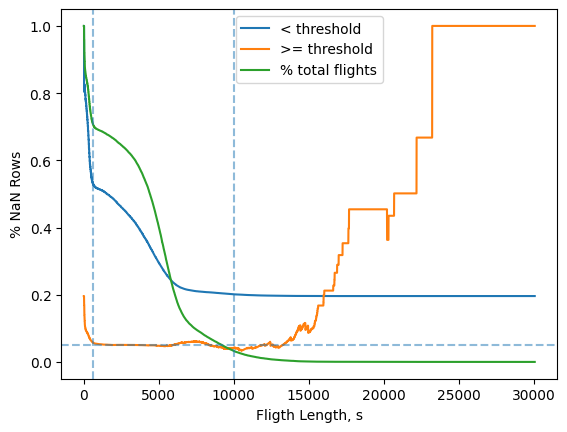

In [32]:
df = pd.DataFrame(thresholds)
plt.plot(
    df["flight_length"],
    df["lt_threshold"],
    label="< threshold",
)
plt.plot(
    df["flight_length"],
    df["ge_threshold"],
    label=">= threshold",
)
plt.plot(
    df["flight_length"],
    df["num_flights_norm"],
    label="% total flights",
)
plt.axhline(y=0.05, linestyle="--", alpha=0.5)
plt.axvline(x=10 * 60, linestyle="--", alpha=0.5)
plt.axvline(x=10_000, linestyle="--", alpha=0.5)
plt.xlabel("Fligth Length, s")
plt.ylabel("% NaN Rows")
plt.legend()

In [33]:
threshold = 10 * 60  # s
short_flights = pct_nan_df[pct_nan_df["flight_length"] < threshold]
long_flights = pct_nan_df[pct_nan_df["flight_length"] >= threshold]

In [34]:
short_flights.describe()

,flight_id,flight_length,pct_nan
count,8427.000000,8427.000000,8427.000000
mean,16853.445354,195.774060,0.531944
std,9618.843872,177.121492,0.412814
min,3.000000,12.000000,0.000000
25%,8436.500000,29.000000,0.134831
50%,16780.000000,123.000000,0.400000
75%,25585.500000,356.000000,1.000000
max,32818.000000,590.000000,1.000000


In [35]:
long_flights.describe()

,flight_id,flight_length,pct_nan
count,20508.000000,20508.000000,20508.000000
mean,16869.442803,5392.506924,0.058105
std,9330.643252,2319.749367,0.226703
min,1.000000,600.000000,0.000000
25%,8910.250000,4168.000000,0.000000
50%,16927.500000,5238.000000,0.000192
75%,25108.250000,6232.000000,0.000389
max,32820.000000,30059.000000,1.000000


### Identify Any Correlation between Features
- Loop over each cluster, calculate correlation matrix for each flight, record corr > 0.90
- Observed a high number of NaNs result in false correlation by dropping the number of points
- Filtered each fligth length > 30 mins, skipped any time there are > 50% NaNs in sensor readings
- Looked at correlation between all 23 sensor readings/features

In [ ]:
def get_corr_df(labels: list[str]) -> pd.DataFrame:
    """Returns correlation dataframe given labels"""
    parq_path = PROJECT_DIR / "data" / "corr.parquet"  # assumes same labels!
    if parq_path.exists():
        return pd.read_parquet(parq_path)

    corr = []
    for label in labels:
        # cluster df
        cluster = label_cluster_map[label]
        cluster_df = get_cluster_df(cluster)

        # Calculate percentage of rows with NA values before dropping
        rows_with_na = cluster_df.isna().any(axis=1).sum()
        nrows = cluster_df.shape[0]
        pct_na = rows_with_na / nrows * 100 if nrows > 0 else 0
        print(f"{label=} has {pct_na=:.2f}")

        # check shape
        if cluster_df.shape[0] == 0:
            continue

        # loop over each flight
        assert cluster_df.index.name == "flight_id"
        for flight_id in cluster_df.index.unique():
            # Filter by flight
            flight_mask = cluster_df.index == flight_id
            flight_df = cluster_df[flight_mask]

            # Skip if short/long flight
            if flight_df.shape[0] < 10 * 60 or flight_df.shape[0] > 167 * 60:  # s
                continue

            # Correlation
            corr_df = flight_df[feature_columns].corr()

            # Look only at top right
            upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))
            high_corr = upper_tri.stack()
            high_corr = high_corr[abs(high_corr) > 0.90]

            # Record pairs with correlation > 0.90
            for (f1, f2), corr_value in high_corr.items():
                # Check number of NaN
                data = flight_df[[f1, f2]]
                flight_time = data.shape[0]
                num_nans = data.isna().any(axis=1).sum()
                if num_nans > 0.5 * flight_time:  # > 50% NaN
                    continue

                corr.append(
                    {
                        "label": label,
                        "flight_id": flight_id,
                        "feature_1": f1,
                        "feature_2": f2,
                        "correlation": corr_value,
                    }
                )

    # to df
    high_corr = pd.DataFrame(sorted(corr, key=lambda x: x["correlation"], reverse=True))
    high_corr.to_parquet(parq_path)

    return high_corr

In [ ]:
# parq_path = PROJECT_DIR / "data" / "corr.parquet"
# high_corr = pd.DataFrame(sorted(corr, key=lambda x: x["correlation"], reverse=True))
# high_corr.to_parquet(parq_path)

In [42]:
labels = [
    "intake gasket leak/damage",
    "rocker cover leak/loose/damage",
    "intake tube/bolt/seal/boot loose or damage",
    "baffle crack/damage/loose/miss",
    "baffle plug need repair/replace",
]
high_corr = get_corr_df(labels)
high_corr.head(10)

,label,flight_id,feature_1,feature_2,correlation
0,intake gasket leak/damage,1617,volt1,volt2,1.000000
1,rocker cover leak/loose/damage,12303,E1 CHT2,E1 CHT4,0.999994
2,rocker cover leak/loose/damage,13475,E1 CHT3,E1 CHT4,0.999984
3,rocker cover leak/loose/damage,13475,E1 CHT1,E1 CHT3,0.999983
4,intake gasket leak/damage,21697,E1 CHT1,E1 CHT2,0.999979
5,rocker cover leak/loose/damage,10274,E1 CHT2,E1 CHT4,0.999976
6,intake tube/bolt/seal/boot loose or damage,27375,E1 CHT3,E1 CHT4,0.999966
7,intake gasket leak/damage,25104,E1 CHT2,E1 CHT4,0.999965
8,intake gasket leak/damage,2662,E1 CHT2,E1 CHT4,0.999962
9,rocker cover leak/loose/damage,13475,E1 CHT1,E1 CHT2,0.999961


In [43]:
# how many total flights show > .90 correlation?
len(high_corr["flight_id"].unique())

12748

In [48]:
# (approximately) how many fligths were looked at?
count = 0
flight_ids = []
for label in labels:
    cluster = label_cluster_map[label]
    cluster_df = get_cluster_df(cluster)
    assert cluster_df.index.name == "flight_id"
    flight_ids.extend(list(cluster_df.index.unique()))
print(len(set(flight_ids)))
    


19167


In [50]:
def scatter_plot_corr(flight_id: int, f1: str, f2: str) -> None:
    """Plots two features and the correlation. Drops NaN"""
    flight_df = get_flight_df(flight_id)
    flight_df.dropna(inplace=True)
    if flight_df.shape[0] == 0:
        print(f"{flight_id=} is empty!")
        return

    x = flight_df[f1].values
    y = flight_df[f2].values

    # feature 1
    fig, axes = plt.subplots(1, 3)
    axes[0].scatter(range(len(x)), x)
    axes[0].set_title(f1)
    axes[0].set_ylabel(f1)

    # feature 2
    axes[1].scatter(range(len(y)), y)
    axes[1].set_title(f2)
    axes[1].set_ylabel(f2)

    # feature 1 vs 2
    axes[2].scatter(x, y)
    axes[2].set_xlabel(f1)
    axes[2].set_ylabel(f2)

    coeff = np.corrcoef(x, y)[0, 1]
    axes[2].set_title(f"{coeff=:0.3f}")

    fig.suptitle(f"{flight_id=}")
    fig.set_layout_engine("constrained")

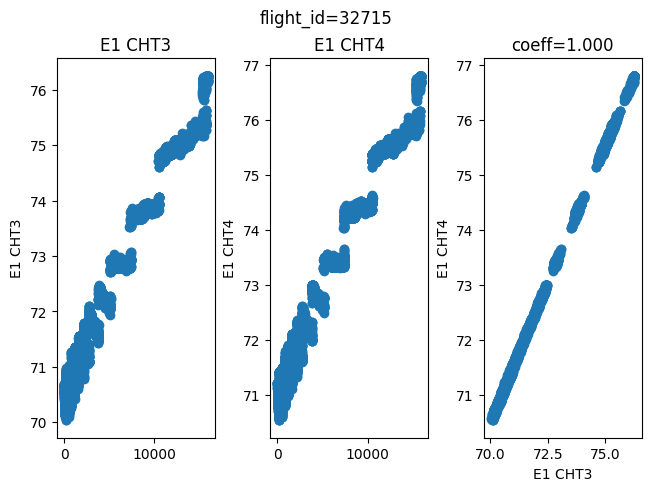

In [51]:
# Plot two features and the linear correlation

# flight_id = 8952
# feature_1 = "volt1"
# feature_2 = "volt2"

flight_id = 32715
feature_1 = "E1 CHT3"
feature_2 = "E1 CHT4"

scatter_plot_corr(flight_id, feature_1, feature_2)

In [52]:
def corr_heatmap(flight_id: int) -> None:
    """Plots correlation heatmap given flight id for all 23 features"""
    flight_df = get_flight_df(flight_id)
    flight_df.dropna(inplace=True)
    if flight_df.shape[0] == 0:
        print(f"{flight_id=} is empty!")
        return
    sns.heatmap(flight_df[feature_columns].corr())  # , annot=True)
    plt.title(f"{flight_id=}")

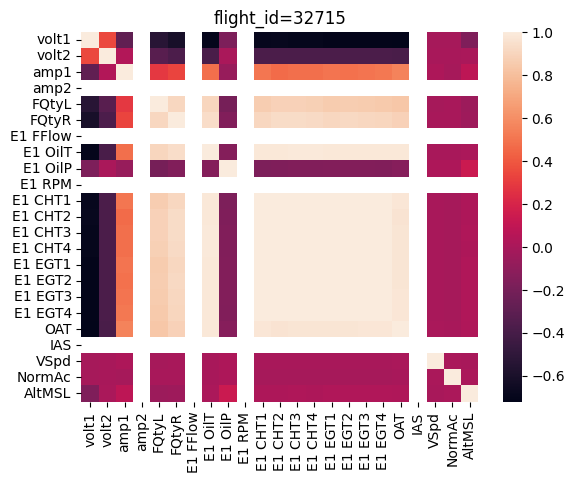

In [53]:
corr_heatmap(flight_id)

In [54]:
def pair_plot(flight_id: int, features: list[str]) -> None:
    """Plots pairplot given flight id and sensor features"""
    flight_df = get_flight_df(flight_id).dropna()

    # Plot
    plt.figure()
    sns.pairplot(flight_df[features], corner=True)
    plt.suptitle(f"{flight_id=}")

<Figure size 640x480 with 0 Axes>

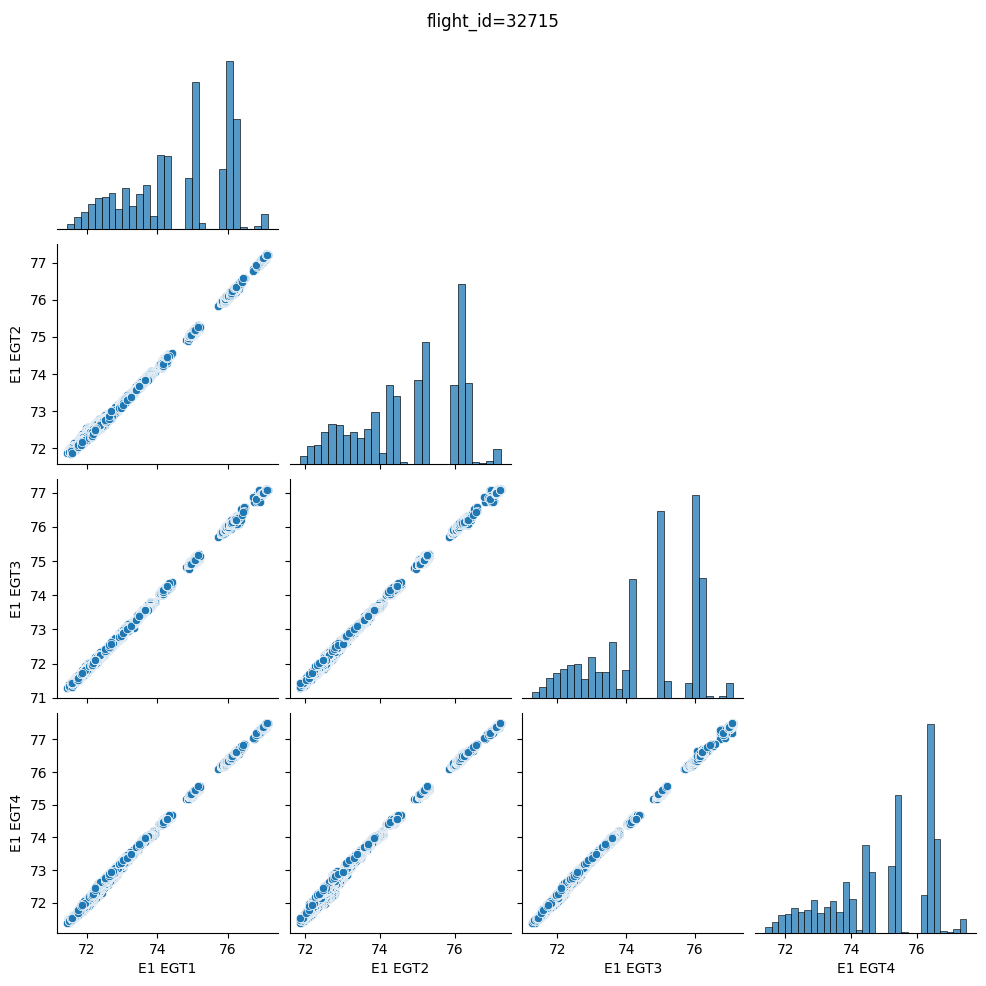

In [55]:
# Plot
features = [
    "E1 EGT1",
    "E1 EGT2",
    "E1 EGT3",
    "E1 EGT4",
    # "E1 OilP",
    # "E1 RPM",
]
flight_id = 32715

pair_plot(flight_id, features)

In [56]:
corr_pairs = []
for pair in high_corr[["feature_1", "feature_2"]].values:
    corr_pairs.append(tuple(sorted(pair)))
counter = Counter(corr_pairs)

counter.most_common(10)

[(('E1 EGT1', 'E1 EGT3'), 12613),
 (('E1 EGT2', 'E1 EGT4'), 12512),
 (('E1 EGT3', 'E1 EGT4'), 12500),
 (('E1 EGT2', 'E1 EGT3'), 12415),
 (('E1 EGT1', 'E1 EGT4'), 12383),
 (('E1 EGT1', 'E1 EGT2'), 12324),
 (('E1 OilP', 'E1 RPM'), 11997),
 (('E1 CHT2', 'E1 CHT4'), 11817),
 (('E1 CHT1', 'E1 CHT3'), 11791),
 (('E1 CHT3', 'E1 CHT4'), 11786)]

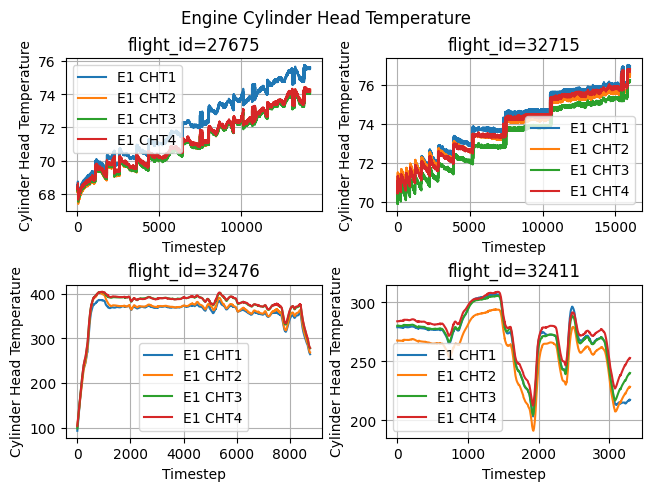

In [57]:
# Plot Cylinder Head Temps
flight_ids = [[27675, 32715], [32476, 32411]]
columns = ["E1 CHT1", "E1 CHT2", "E1 CHT3", "E1 CHT4"]

fig, axes = plt.subplots(2, 2)
for i, row in enumerate(flight_ids):
    for j, flight_id in enumerate(row):
        flight_df = get_flight_df(flight_id)
        ax = axes[i, j]
        for column in columns:
            ax.plot(flight_df["timestep"], flight_df[column], label=column)
        ax.set_title(f"{flight_id=}")
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Cylinder Head Temperature")

        ax.grid(True)
        ax.legend()
fig.suptitle("Engine Cylinder Head Temperature")
fig.set_layout_engine("constrained")

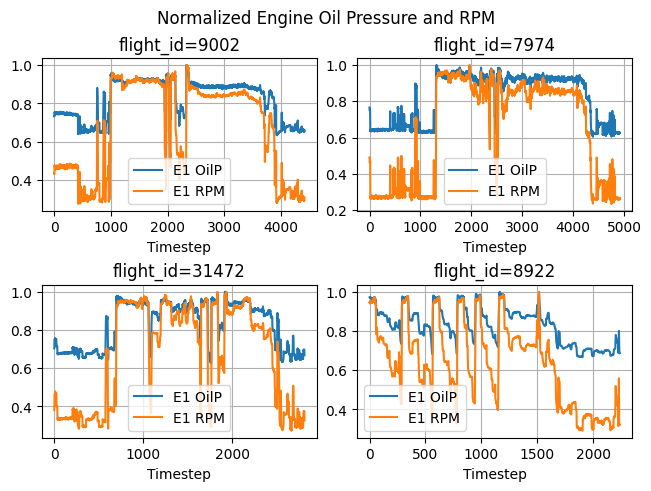

In [58]:
# Plot OilP vs RPM
flight_ids = [[9002, 7974], [31472, 8922]]

fig, axes = plt.subplots(2, 2)
for i, row in enumerate(flight_ids):
    for j, flight_id in enumerate(row):
        flight_df = get_flight_df(flight_id)

        ax = axes[i, j]

        # normalize OilP
        max_oilp = flight_df["E1 OilP"].max()
        flight_df["oilp_norm"] = flight_df["E1 OilP"].apply(lambda x: x / max_oilp)
        ax.plot(flight_df["timestep"], flight_df["oilp_norm"], label="E1 OilP")

        # normalize RPM
        max_rpm = flight_df["E1 RPM"].max()
        flight_df["rpm_norm"] = flight_df["E1 RPM"].apply(lambda x: x / max_rpm)
        ax.plot(flight_df["timestep"], flight_df["rpm_norm"], label="E1 RPM")

        ax.set_title(f"{flight_id=}")
        ax.set_xlabel("Timestep")

        ax.grid(True)
        ax.legend()
fig.suptitle("Normalized Engine Oil Pressure and RPM")
fig.set_layout_engine("constrained")

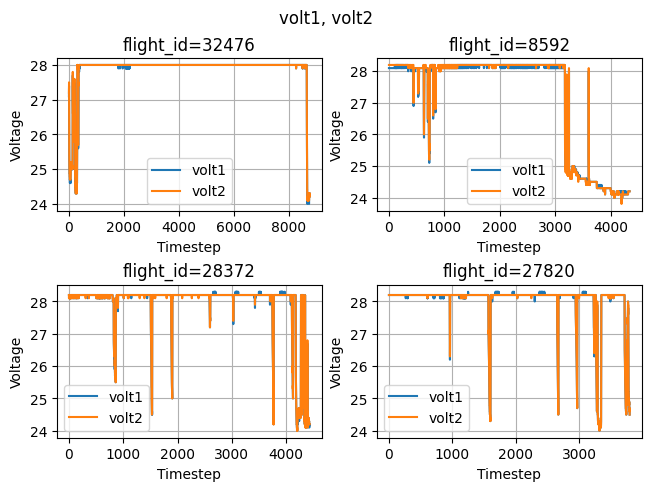

In [340]:
# Plot voltage
flight_ids = [[32476, 8592], [28372, 27820]]
columns = ["volt1", "volt2"]

fig, axes = plt.subplots(2, 2)
for i, row in enumerate(flight_ids):
    for j, flight_id in enumerate(row):
        flight_df = get_flight_df(flight_id)
        ax = axes[i, j]
        for column in columns:
            ax.plot(flight_df["timestep"], flight_df[column], label=column)
        ax.set_title(f"{flight_id=}")
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Voltage")

        ax.grid(True)
        ax.legend()
fig.suptitle("volt1, volt2")
fig.set_layout_engine("constrained")

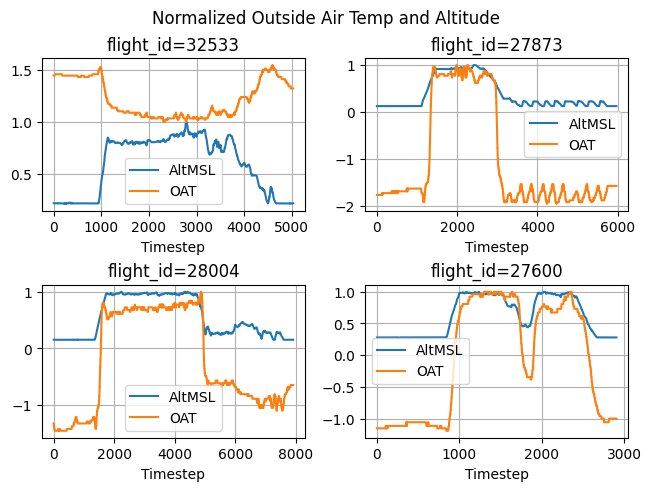

In [59]:
# Plot OAT, AltMSL
flight_ids = [[32533, 27873], [28004, 27600]]
# columns = ["OAT", "AltMSL"]

fig, axes = plt.subplots(2, 2)
for i, row in enumerate(flight_ids):
    for j, flight_id in enumerate(row):
        flight_df = get_flight_df(flight_id)

        ax = axes[i, j]

        # normalize AltMSL
        max_alt = flight_df["AltMSL"].max()
        flight_df["altmsl_norm"] = flight_df["AltMSL"].apply(lambda x: x / max_alt)
        ax.plot(flight_df["timestep"], flight_df["altmsl_norm"], label="AltMSL")

        # normalize OAT
        max_oat = flight_df["OAT"].max()
        flight_df["oat_norm"] = flight_df["OAT"].apply(lambda x: x / max_oat)
        ax.plot(flight_df["timestep"], flight_df["oat_norm"], label="OAT")

        ax.set_title(f"{flight_id=}")
        ax.set_xlabel("Timestep")

        ax.grid(True)
        ax.legend()
fig.suptitle("Normalized Outside Air Temp and Altitude")
fig.set_layout_engine("constrained")

## Engine

Ok, lets start with one aircraft part and see if we can use a model to decipher when is optimal time to schedule maintenance to improve cost by repairing instead of replacing.

We can look at engine, this is a good part to look at for the following reasons
- appears in 2959 maintenance issues according to our first df
- Has a high replacement cost: 839.99 USD
- has sensor relationships from the second df: FFflow, RPM, OilP, OilT

In [60]:
# engine df
hierarchy = "engine"

hierarchy_df = get_hierarchy_df(hierarchy)
if hierarchy_df.index.name != "flight_id":
    hierarchy_df.set_index("flight_id", inplace=True)
hierarchy_df.head()

,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,...,E1 EGT2,E1 EGT3,E1 EGT4,OAT,IAS,VSpd,NormAc,AltMSL,timestep,cluster
flight_id,,,,,,,,,,,,,,,,,,,,,
6866,27.9,27.9,4.1,0.3,23.22,24.0,2.33,64.72,62.93,1019.0,...,938.69,919.91,939.09,-6.2,0.0,-0.14,0.00,842.2,0,c_23
6866,27.9,27.9,4.1,0.3,23.22,24.0,2.33,64.72,62.93,1019.0,...,938.69,919.91,939.09,-6.2,0.0,-0.14,0.00,842.2,1,c_23
6866,28.0,27.9,4.0,0.3,23.24,24.0,2.32,64.77,63.44,1042.1,...,944.93,925.34,943.07,-6.2,0.0,12.19,0.01,841.9,2,c_23
6866,28.0,27.9,4.0,0.4,23.24,24.0,2.58,64.79,64.96,1112.4,...,948.64,928.90,946.87,-6.2,0.0,9.90,0.01,841.8,3,c_23
6866,28.0,27.9,3.9,0.3,23.24,24.0,2.75,64.81,66.73,1193.2,...,955.34,938.93,955.80,-6.2,0.0,7.55,0.01,841.6,4,c_23


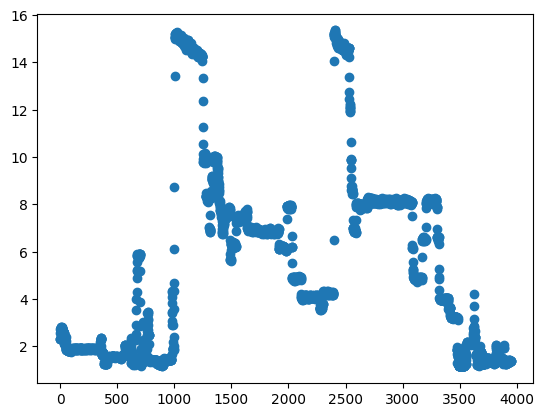

In [61]:
# E1 FFlow
flight_id = 6866
flight_mask = hierarchy_df.index == flight_id
y = "E1 FFlow"
plt.scatter(
    hierarchy_df.loc[flight_mask, "timestep"], hierarchy_df.loc[flight_mask, y]
);

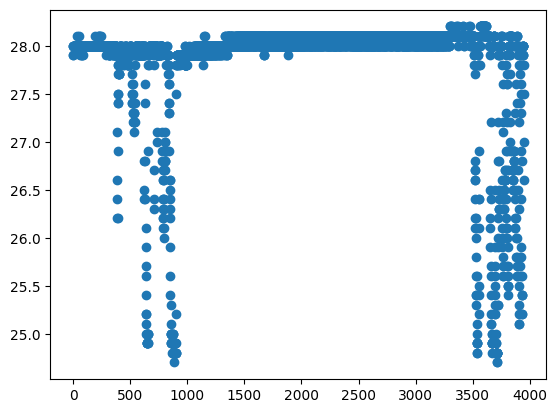

In [62]:
# volt1
plt.scatter(
    hierarchy_df.loc[flight_mask, "timestep"], hierarchy_df.loc[flight_mask, "volt1"]
);

In [63]:
# Need to reset index to access Master Index as a column
flight_header_df = flight_header_df.reset_index()

flight_header_df.head()


,flight_id,before_after,date_diff,flight_length,label,hierarchy,number_flights_before,part_name,prices_usd
0,1,before,-1,4723.0,intake gasket leak/damage,NaN,0,intake gasket,4.5
1,2,before,-2,4649.0,intake gasket leak/damage,NaN,3,intake gasket,4.5
2,3,same,0,40.0,intake gasket leak/damage,NaN,-1,intake gasket,4.5
3,4,before,0,14.0,intake gasket leak/damage,NaN,0,intake gasket,4.5
4,5,same,0,683.0,intake gasket leak/damage,NaN,-1,intake gasket,4.5


In [64]:
# Merge flight_header_df  info into hierarchy_df so we can caterogize flights
# Note that index has been dropped
hierarchy_df = hierarchy_df.merge(
    # flight_header_df[["flight_id", "hierarchy", "label", "number_flights_before", "before_after"]],
    flight_header_df,
    left_on="flight_id",
    right_on="flight_id",
    how="left",
)
hierarchy_df.head()

,flight_id,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,...,timestep,cluster,before_after,date_diff,flight_length,label,hierarchy,number_flights_before,part_name,prices_usd
0,6866,27.9,27.9,4.1,0.3,23.22,24.0,2.33,64.72,62.93,...,0,c_23,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99
1,6866,27.9,27.9,4.1,0.3,23.22,24.0,2.33,64.72,62.93,...,1,c_23,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99
2,6866,28.0,27.9,4.0,0.3,23.24,24.0,2.32,64.77,63.44,...,2,c_23,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99
3,6866,28.0,27.9,4.0,0.4,23.24,24.0,2.58,64.79,64.96,...,3,c_23,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99
4,6866,28.0,27.9,3.9,0.3,23.24,24.0,2.75,64.81,66.73,...,4,c_23,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99


In [65]:
hierarchy_df["number_flights_before"].unique()

array([-1,  2,  4,  3,  0,  1])

In [66]:
flight_header_df["before_after"].value_counts(normalize=True)

before_after
before    0.419561
after     0.355659
same      0.224780
Name: proportion, dtype: float64

In [67]:
# create target column to hold 0 if the current flight had maintenance, 1 if it did not and it was flight before maintenance
# Assign after maintenance flights with class 0
# Assign before maintenance flights class 1
# hierarchy_df["target"] = (hierarchy_df["number_flights_before"] > 0).astype(int)
hierarchy_df["target"] = (hierarchy_df["before_after"] == "before").astype(int)
hierarchy_df["target"].value_counts(normalize=True)

target
1    0.553365
0    0.446635
Name: proportion, dtype: float64

- Larger proportion of engine hierarchy flights occured before maintenance than in entire dataset

In [68]:
# also create near_failure column to hold 1 if the current flight was within 1-3 flights before maintenance
hierarchy_df["near_failure"] = (
    hierarchy_df["number_flights_before"].between(1, 3)
).astype(int)
hierarchy_df.head()

,flight_id,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,...,before_after,date_diff,flight_length,label,hierarchy,number_flights_before,part_name,prices_usd,target,near_failure
0,6866,27.9,27.9,4.1,0.3,23.22,24.0,2.33,64.72,62.93,...,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99,0,0
1,6866,27.9,27.9,4.1,0.3,23.22,24.0,2.33,64.72,62.93,...,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99,0,0
2,6866,28.0,27.9,4.0,0.3,23.24,24.0,2.32,64.77,63.44,...,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99,0,0
3,6866,28.0,27.9,4.0,0.4,23.24,24.0,2.58,64.79,64.96,...,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99,0,0
4,6866,28.0,27.9,3.9,0.3,23.24,24.0,2.75,64.81,66.73,...,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99,0,0


In [69]:
# Create aggregated features dataframe for each sensor statistics
agg_features = hierarchy_df.groupby("flight_id").agg(
    {
        "E1 RPM": ["mean", "std", "max", "min"],
        "E1 OilP": ["mean", "std", "min"],
        "E1 OilT": ["mean", "std", "max"],
        "volt1": ["mean", "min"],
        "amp1": ["mean", "max"],
        "E1 CHT1": ["mean", "max"],
        "E1 EGT1": ["mean", "max"],
        "AltMSL": ["mean"],
        "IAS": ["mean", "max"],
        "NormAc": ["std"],
    }
)
agg_features.columns = ["_".join(col) for col in agg_features.columns]
agg_features.reset_index(inplace=True)

In [70]:
# merge target column into agg_features to create model_df, so we can plot
model_df = agg_features.merge(
    hierarchy_df[["flight_id", "target"]].drop_duplicates(), on="flight_id", how="left"
)
model_df.head()

,flight_id,E1 RPM_mean,E1 RPM_std,E1 RPM_max,E1 RPM_min,E1 OilP_mean,E1 OilP_std,E1 OilP_min,E1 OilT_mean,E1 OilT_std,...,amp1_max,E1 CHT1_mean,E1 CHT1_max,E1 EGT1_mean,E1 EGT1_max,AltMSL_mean,IAS_mean,IAS_max,NormAc_std,target
0,6866,1732.270061,634.393739,2502.7,640.0,65.781502,6.938748,50.07,128.552617,30.877475,...,5.1,280.555152,363.09,1210.151487,1509.42,2120.055280,60.492401,115.32,0.032311,0
1,6871,1671.844004,548.143626,2468.7,773.7,64.422673,5.563563,53.20,142.744267,16.482259,...,3.0,292.307199,404.31,1260.891217,1442.45,1843.520300,56.108425,117.51,0.074388,1
2,6876,2145.471857,569.996895,2609.6,602.1,75.673824,6.343249,53.89,133.713464,21.391360,...,5.1,NaN,NaN,1355.232677,1523.16,3298.329430,92.701768,126.99,0.046270,1
3,6878,1516.793506,647.394744,2548.8,551.3,61.268964,6.962468,45.71,140.593877,31.101684,...,9.8,258.869558,342.13,1050.118413,1240.87,1145.469443,43.776903,99.02,0.071500,0
4,6880,1985.676920,642.264648,2557.7,639.1,70.623175,7.314927,52.57,140.502183,29.156996,...,10.8,297.160784,374.08,1324.473955,1505.24,3208.703502,71.657501,116.57,0.070693,0


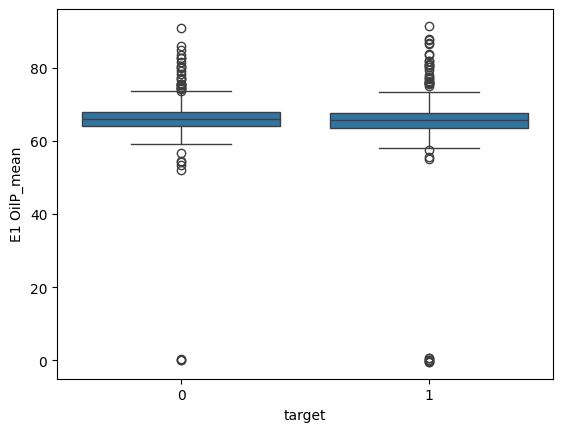

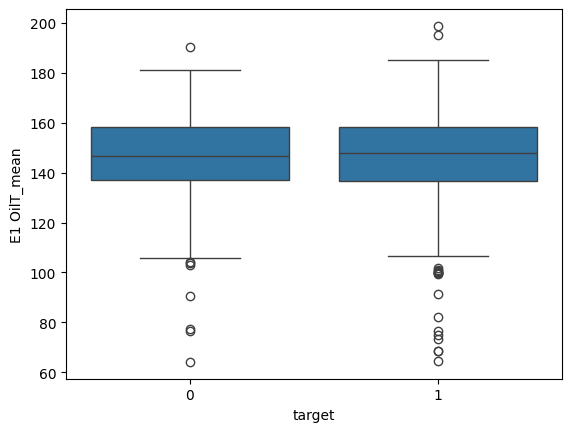

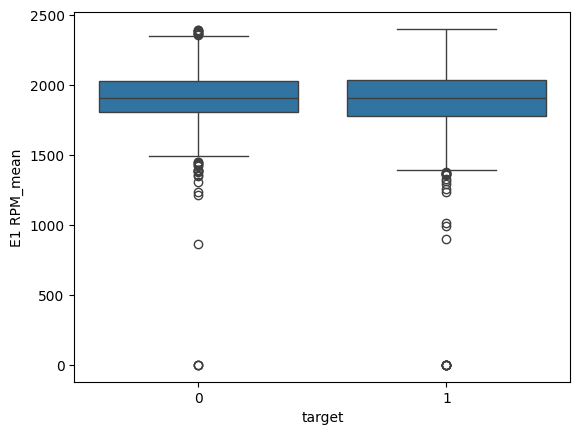

In [71]:
# Plot boxplots of selected features by target
sns.boxplot(x="target", y="E1 OilP_mean", data=model_df)
plt.show()
sns.boxplot(x="target", y="E1 OilT_mean", data=model_df)
plt.show()
sns.boxplot(x="target", y="E1 RPM_mean", data=model_df)
plt.show()


The boxplots did not tell us much

Lets try something else,

1) Extract one specific flight for Engine part_name
2) Sort by timestep
3) Plot a time-series line chart for one sensor

In [72]:
# Filter just this one flight
flight_id = 6866
single_flight_df = hierarchy_df[hierarchy_df["flight_id"] == flight_id]

# Sort by timestep
single_flight_df = single_flight_df.sort_values("timestep")
single_flight_df.shape

(3949, 36)

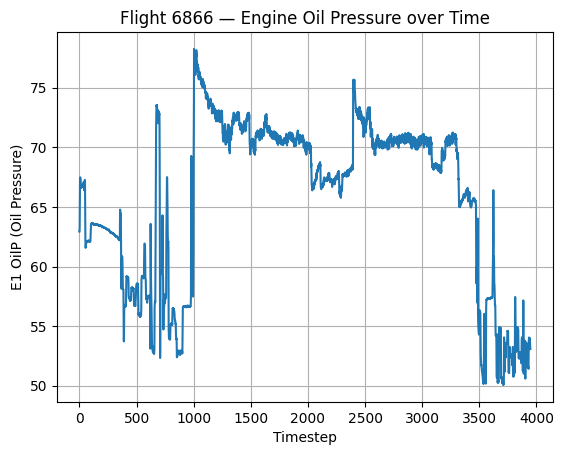

In [73]:
# Plot a time-series line chart for one sensor (E1 OilP)
plt.plot(single_flight_df["timestep"], single_flight_df["E1 OilP"])
plt.title(f"Flight {flight_id} — Engine Oil Pressure over Time")
plt.xlabel("Timestep")
plt.ylabel("E1 OilP (Oil Pressure)")
plt.grid(True)
plt.show()

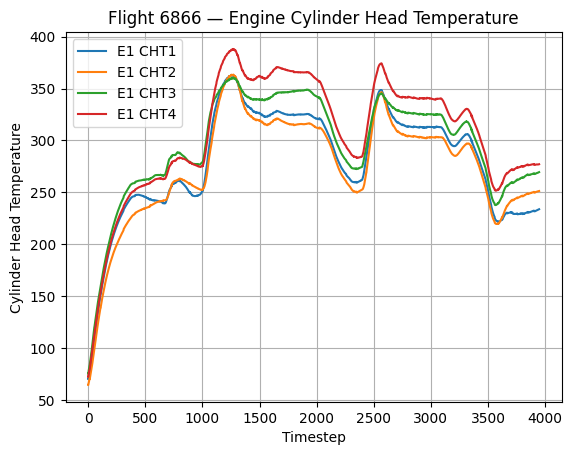

In [74]:
# Plot Engine Cylinder Head Temperature
columns = ["E1 CHT1", "E1 CHT2", "E1 CHT3", "E1 CHT4"]

for column in columns:
    plt.plot(single_flight_df["timestep"], single_flight_df[column], label=column)
plt.title(f"Flight {flight_id} — Engine Cylinder Head Temperature")
plt.xlabel("Timestep")
plt.ylabel("Cylinder Head Temperature")
plt.grid(True)
plt.legend()

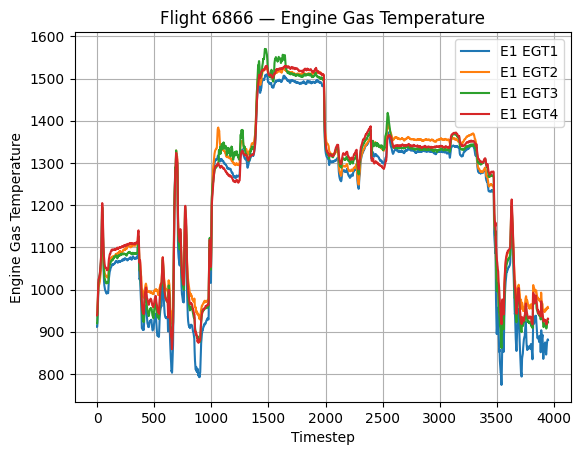

In [75]:
# Plot Engine Gas Temperature
columns = ["E1 EGT1", "E1 EGT2", "E1 EGT3", "E1 EGT4"]

for column in columns:
    plt.plot(single_flight_df["timestep"], single_flight_df[column], label=column)
plt.title(f"Flight {flight_id} — Engine Gas Temperature")
plt.xlabel("Timestep")
plt.ylabel("Engine Gas Temperature")
plt.grid(True)
plt.legend()

In [76]:
# Split before/after maintenance
before_mask = hierarchy_df["before_after"] == "before"
after_mask = hierarchy_df["before_after"] == "after"
before_maintenance_df = hierarchy_df[before_mask]
after_maintenance_df = hierarchy_df[after_mask]

In [77]:
# Manually found flight_id 6871 to have Engine issues and a before maintenance flight
assert 6871 in before_maintenance_df["flight_id"].unique()

# Manually found flight_id 6866 to have Engine issues and a After maintenance flight
assert 6866 in after_maintenance_df["flight_id"].unique()

# create df for before maintenance flight
before_df = hierarchy_df[hierarchy_df["flight_id"] == 6871].sort_values("timestep")

# create df for after maintenance flight
after_df = hierarchy_df[hierarchy_df["flight_id"] == 6866].sort_values("timestep")

after_df.head()

,flight_id,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,...,before_after,date_diff,flight_length,label,hierarchy,number_flights_before,part_name,prices_usd,target,near_failure
0,6866,27.9,27.9,4.1,0.3,23.22,24.0,2.33,64.72,62.93,...,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99,0,0
1,6866,27.9,27.9,4.1,0.3,23.22,24.0,2.33,64.72,62.93,...,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99,0,0
2,6866,28.0,27.9,4.0,0.3,23.24,24.0,2.32,64.77,63.44,...,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99,0,0
3,6866,28.0,27.9,4.0,0.4,23.24,24.0,2.58,64.79,64.96,...,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99,0,0
4,6866,28.0,27.9,3.9,0.3,23.24,24.0,2.75,64.81,66.73,...,after,1,3949.0,engine need repair/reinstall/clean,engine,-1,engine,839.99,0,0


### Part vs timestep
view feature performance before and after maintenance to see where the most value from replacing parts would be

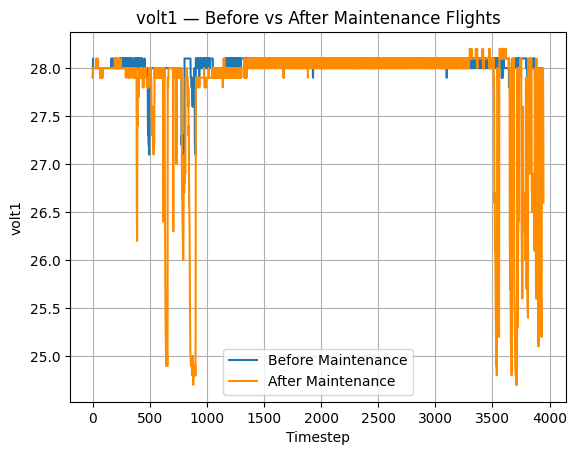

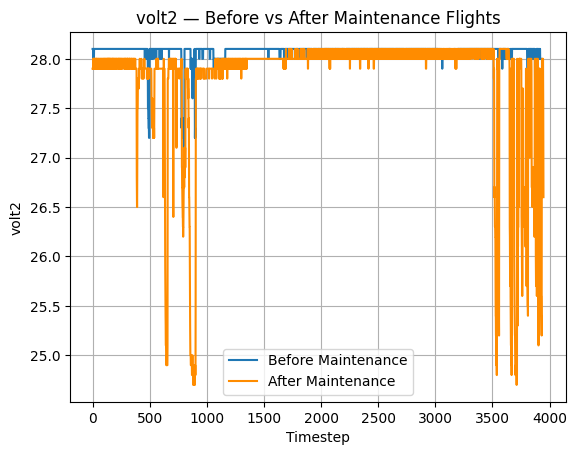

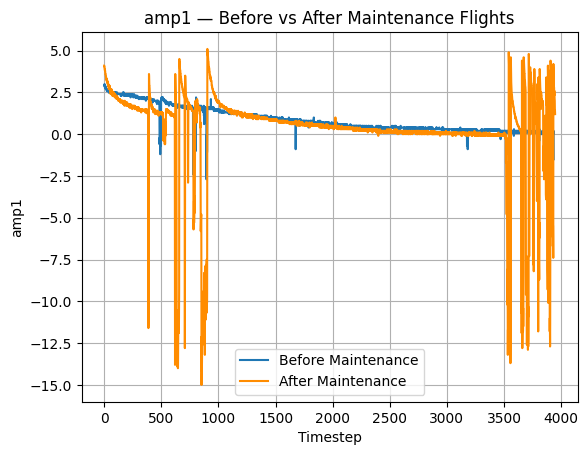

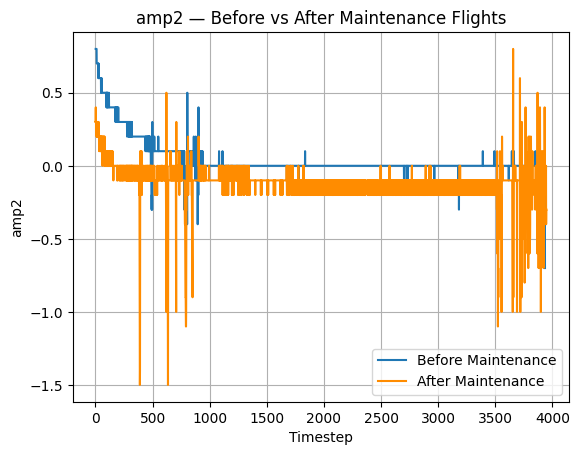

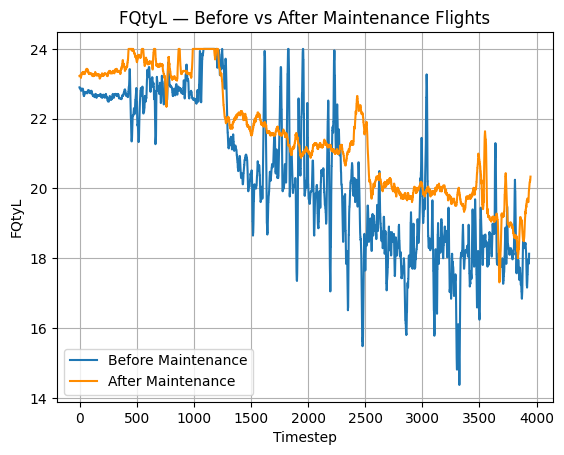

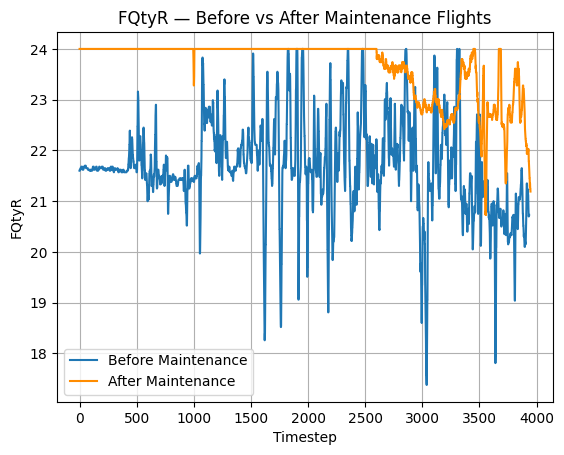

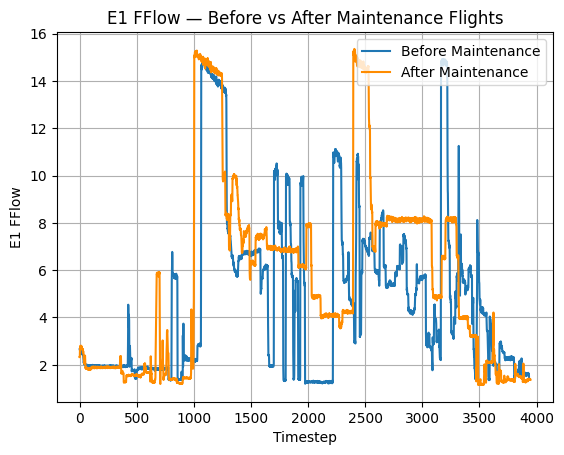

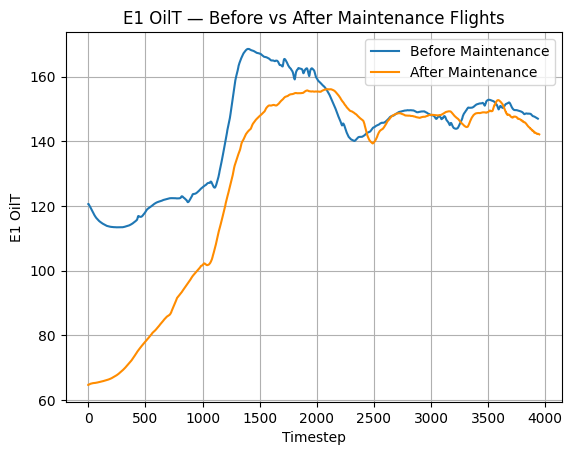

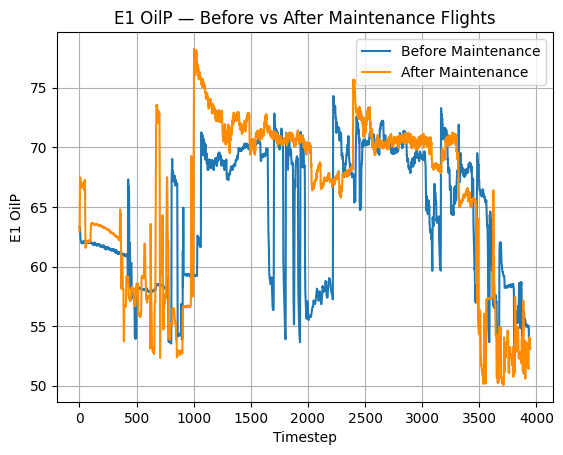

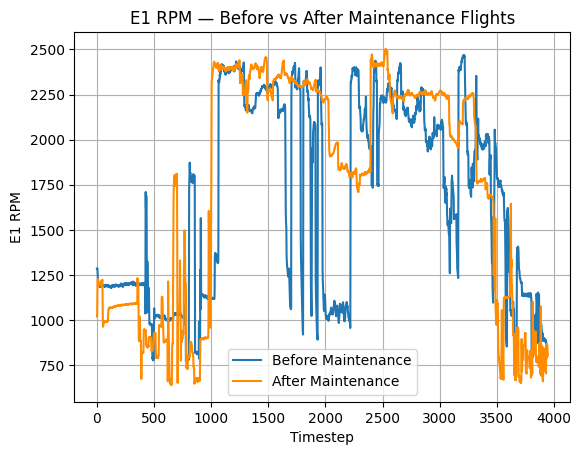

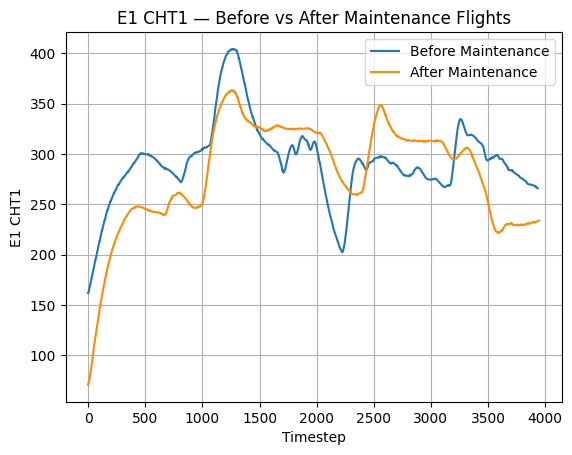

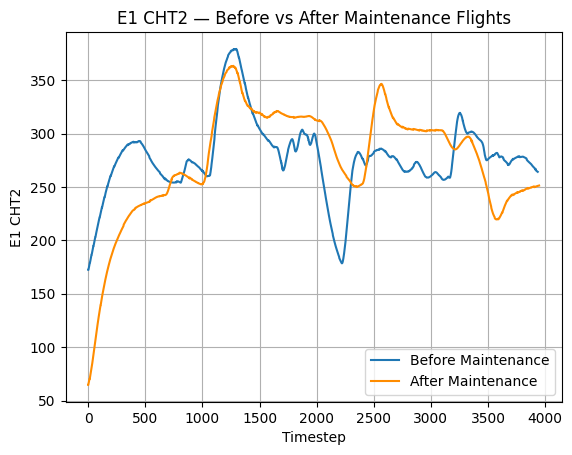

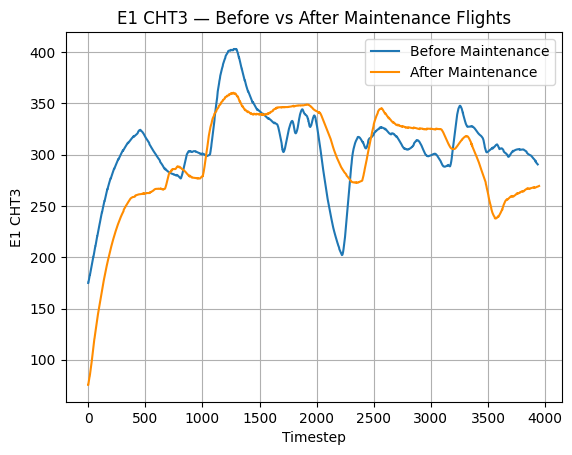

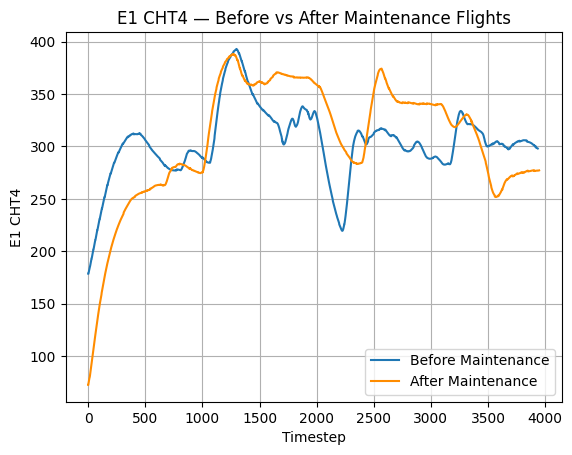

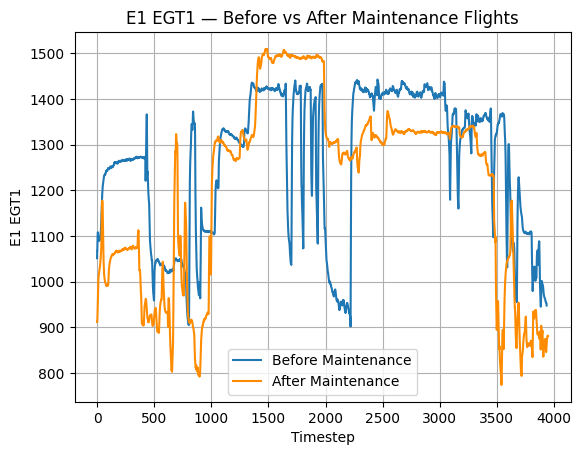

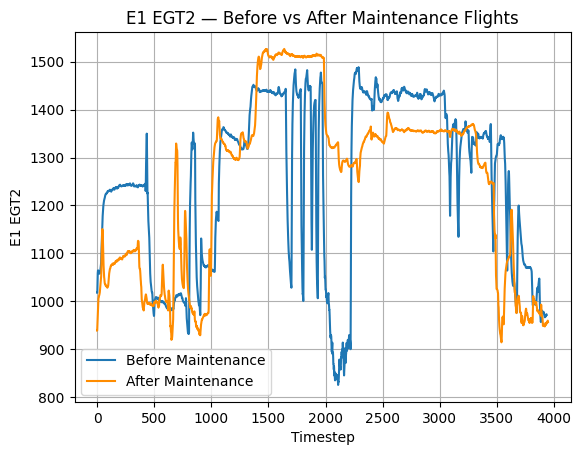

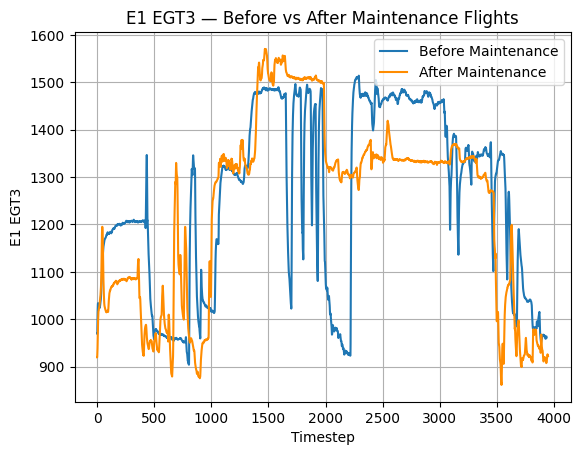

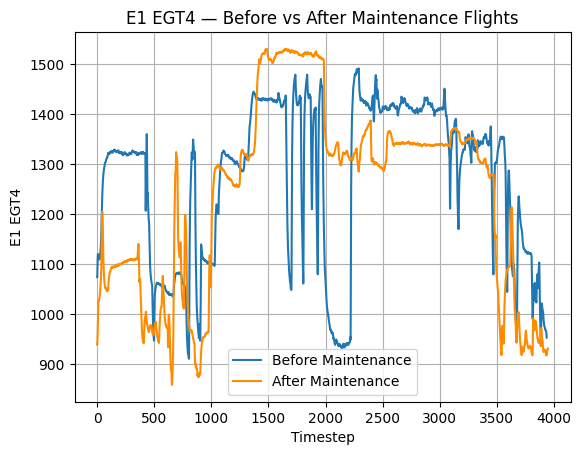

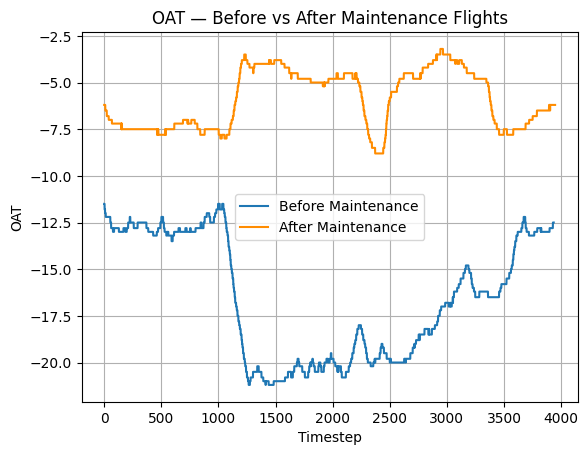

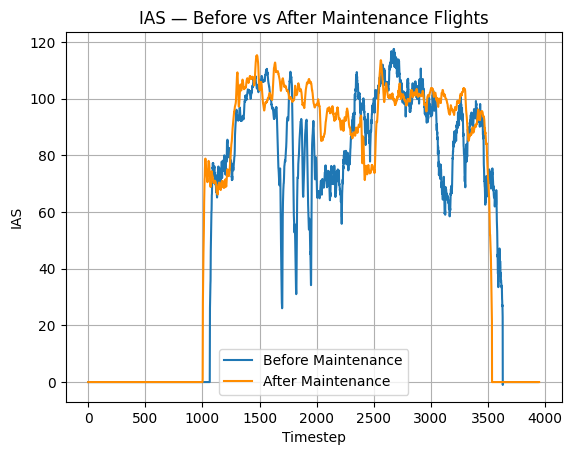

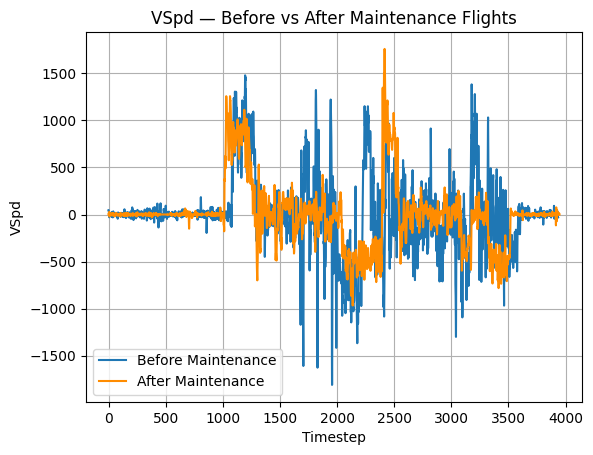

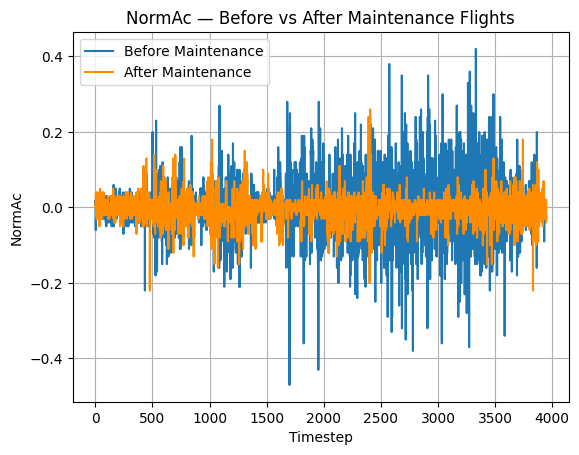

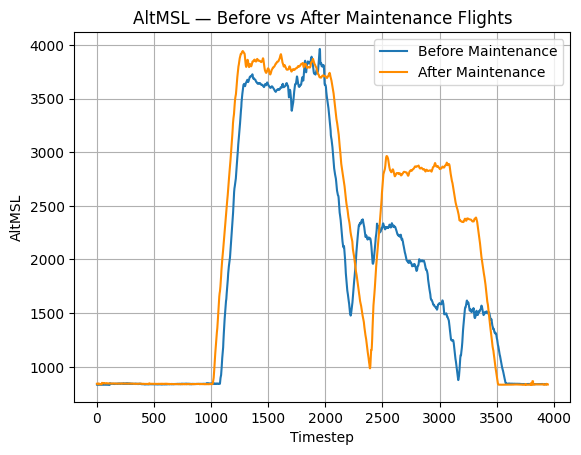

In [ ]:
features = [
    "volt1",
    "volt2",
    "amp1",
    "amp2",
    "FQtyL",
    "FQtyR",
    "E1 FFlow",
    "E1 OilT",
    "E1 OilP",
    "E1 RPM",
    "E1 CHT1",
    "E1 CHT2",
    "E1 CHT3",
    "E1 CHT4",
    "E1 EGT1",
    "E1 EGT2",
    "E1 EGT3",
    "E1 EGT4",
    "OAT",  
    "IAS",
    "VSpd",
    "NormAc",
    "AltMSL",
]

for feat in features:
    # plt.figure(figsize=(12, 6))
    plt.plot(before_df["timestep"], before_df[feat], label="Before Maintenance")
    plt.plot(
        after_df["timestep"],
        after_df[feat],
        label="After Maintenance",
        color="darkorange",
    )

    plt.title(f"{feat} — Before vs After Maintenance Flights")
    plt.xlabel("Timestep")
    plt.ylabel(feat)
    plt.legend()
    plt.grid(True)
    plt.show()
